# Capstone Project - An escape from the City's gray
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

**Amiens** is the **European Youth Capital winner of 2020**. With a cultural events programme combining music, cinema and theatre festivals, some of which happen in the streets, Amiens fully deserves its place as European Youth Capital. Although it is a historical city with the Cathedrale Notre Dame, classified by UNESCO (the 800th anniversary in 2020) there is also a wonderful youth dynamic in Amiens thanks to the university **“La Citadelle”**, which is located in the centre of the town. [1] The main focus of this project is to find an optimal location for a student wanting to live in Amiens. 

Since there are lots of venues in Amiens we will try to detect **locations crowded with venues that appeal more towards students**. We are also particularly interested in **areas that are as close to the university as possible**.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by the students interested in living in Amiens.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing venues in the neighborhood.
* weighted sum of all existing velues in the neighborhood.
* distance of neighborhood from the university.

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of parks and their type and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Université de Picardie Jules Verne, that we are going to use as our center point, will be obtained using **Google Maps API geocoding**.

### Neighborhood Candidates

Let's create latitude & longitude coordinates for centroids of our candidate neighborhoods. We will create a grid of cells covering our area of interest which is aprox. 8x8 killometers centered around Université de Picardie Jules Verne.

Let's first find the latitude & longitude of Université de Picardie Jules Verne using Google Maps' geocoding API.

In [41]:
from getkeys import get_gkey, get_fsqkey
google_api_key = get_gkey()
client_id , client_secret = get_fsqkey()

In [42]:
import requests

def get_coordinates(api_key, address, verbose=False):
    try:
        url = f'https://maps.googleapis.com/maps/api/geocode/json?key={google_api_key}&address={address}'
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        geographical_data = results[0]['geometry']['location'] # get geographical coordinates
        lat = geographical_data['lat']
        lon = geographical_data['lng']
        return [lat, lon]
    except:
        return [None, None]
    
address = 'Ctre Ville, Amiens, France'
amiens_center = get_coordinates(google_api_key, address)
latitude = amiens_center[0]
longitude = amiens_center[1]
print(f'The geograpical coordinate of {address} are {amiens_center}.')

The geograpical coordinate of Ctre Ville, Amiens, France are [49.892168, 2.2994263].


Now let's create a grid of area candidates, equaly spaced, centered around city center and within ~5km from Ctre Ville. Our neighborhoods will be defined as circular areas with a radius of 300 meters, so our neighborhood centers will be 600 meters apart.

To accurately calculate distances we need to create our grid of locations in Cartesian 2D coordinate system which allows us to calculate distances in meters (not in latitude/longitude degrees). Then we'll project those coordinates back to latitude/longitude degrees to be shown on Folium map. So let's create functions to convert between WGS84 spherical coordinate system (latitude/longitude degrees) and UTM Cartesian coordinate system (X/Y coordinates in  meters).

In [43]:
import shapely.geometry

import pyproj

import math

def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

def xy_to_lonlat(x, y):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=33, datum='WGS84')
    lonlat = pyproj.transform(proj_xy, proj_latlon, x, y)
    return lonlat[0], lonlat[1]

def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

print('Coordinate transformation check')
print('-------------------------------')
print(f'Université de Picardie Jules Verne longitude={longitude}, latitude={latitude}.')
x, y = lonlat_to_xy(longitude, latitude)
print(f'Université de Picardie Jules Verne UTM X={x}, Y={y}')
lo, la = xy_to_lonlat(x, y)
print(f'Université de Picardie Jules Verne longitude={lo}, latitude={la}.')

Coordinate transformation check
-------------------------------
Université de Picardie Jules Verne longitude=2.2994263, latitude=49.892168.
Université de Picardie Jules Verne UTM X=-410927.1734301038, Y=5604445.303775529
Université de Picardie Jules Verne longitude=2.2994263000000013, latitude=49.89216799999999.


Let's create a **hexagonal grid of cells**: we offset every other row, and adjust vertical row spacing so that **every cell center is equally distant from all it's neighbors**.

In [44]:
amiens_center_x, amiens_center_y = lonlat_to_xy(longitude, latitude) # City center in Cartesian coordinates

k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_min = amiens_center_x - 5000
x_step = 600
y_min = amiens_center_y - 5000 - (int(21/k)*k*600 - 10000)/2
y_step = 600 * k 

latitudes = []
longitudes = []
distances_from_center = []
xs = []
ys = []
for i in range(0, int(21/k)):
    y = y_min + i * y_step
    x_offset = 300 if i%2==0 else 0
    for j in range(0, 21):
        x = x_min + j * x_step + x_offset
        distance_from_center = calc_xy_distance(amiens_center_x, amiens_center_y, x, y)
        if (distance_from_center <= 5001):
            lon, lat = xy_to_lonlat(x, y)
            latitudes.append(lat)
            longitudes.append(lon)
            distances_from_center.append(distance_from_center)
            xs.append(x)
            ys.append(y)

print(len(latitudes), 'candidate neighborhood centers generated.')

251 candidate neighborhood centers generated.


Lets visualize each candidate neighborhood we have generated so far

In [45]:
import folium

map_amiens = folium.Map(location=[latitude,longitude], zoom_start=13)
folium.Marker([latitude,longitude], popup='Charing Cross').add_to(map_amiens)
for lat, lon in zip(latitudes, longitudes):
    folium.Circle([lat, lon], radius=300, color='blue', fill=False).add_to(map_amiens)
map_amiens

And let's visualize each neighborhood's center

In [47]:
map_amiens = folium.Map(location=[latitude,longitude], zoom_start=13)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='red', icon='home')).add_to(map_amiens)
for lat, lon in zip(latitudes, longitudes):
    folium.Marker([lat, lon]).add_to(map_amiens)
map_amiens

In [48]:
def get_address(google_api_key, latitude, longitude, verbose=False):
    try:
        url = f'https://maps.googleapis.com/maps/api/geocode/json?key={google_api_key}&latlng={latitude},{longitude}'
        response = requests.get(url).json()
        if verbose:
            print('Google Maps API JSON result =>', response)
        results = response['results']
        address = results[0]['formatted_address']
        return address
    except:
        return None

addr = get_address(google_api_key, amiens_center[0], amiens_center[1])

Now lets create a Pandas DataFrame with the above data and save it with pickle for later use.

In [49]:
import pickle
import pandas as pd

loaded = False
try:
    with open('locations.pkl', 'rb') as f:
        df_locations = pickle.load(f)
        addresses = [address for address in df_locations['Address']]
        loaded = True
except:
    pass

if loaded == False:
    print('Obtaining location addresses: ', end='')
    addresses = []
    for lat, lon in zip(latitudes, longitudes):
        address = get_address(google_api_key,lat, lon)
        if address is None or 'amien' not in address.lower():
            address = 'NO ADDRESS'
        address = address.replace(', France', '')
        addresses.append(address)
        print(' .', end='')
    print(' done.')

    df_locations = pd.DataFrame({'Address': addresses,
                             'Latitude': latitudes,
                             'Longitude': longitudes,
                             'X': xs,
                             'Y': ys,
                             'Distance from center': distances_from_center})
    df_locations.to_pickle('./locations.pkl')   

In [50]:
# df_locations = df_locations[df_locations['Address'] != 'NO ADDRESS']

Let's print some addresses

In [51]:
df_locations['Address'][101:110]

101                              A16, 80480 Pont-de-Metz
102           Route de Guignemicourt, 80480 Pont-de-Metz
103               34 Rue de l'Église, 80480 Pont-de-Metz
104                10 Rue du Terrain, 80480 Pont-de-Metz
105    288B Grande Rue du Petit Saint-Jean, 80480 Pon...
106                  53 Rue de la Montagne, 80000 Amiens
107                       580 Rue de Rouen, 80000 Amiens
108             19 Boulevard de Strasbourg, 80000 Amiens
109                       121 Rue de Rouen, 80000 Amiens
Name: Address, dtype: object

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on existing venues for each of these catergories:
* Arts & Entertainment
* Events
* Food
* Nightlife Spot
* Outdoors & Recreation


We're interested in venues in 'Outdoors & Recreation category.

In [11]:
adict = {"Arts & Entertainment" : '4d4b7104d754a06370d81259',
"Event" : '4d4b7105d754a06373d81259',
"Food" : '4d4b7105d754a06374d81259',
"Nightlife Spot" : '4d4b7105d754a06376d81259',
"Outdoors & Recreation" : '4d4b7105d754a06377d81259',}


In [15]:
import json, requests

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', France', '')
    return address

def get_venues_near_location(lat, lon, category, client_id, client_secret, radius=1000, limit=50):
    url = 'https://api.foursquare.com/v2/venues/explore'

    params = dict(
    client_id=client_id,
    client_secret=client_secret,
    v='20200505',
    ll=f'{lat},{lon}',
    limit=limit,
    radius=radius,
    categoryId=category[1]
    )
    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)
    try:
        results = data['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   category[0],
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance']) for item in results]        
    except:
        venues = []
        pass
    return venues

In [16]:
import pickle

def get_venues(lats, lons):

    ven = {}
    print('Obtaining venues around candidate locations:', end='')
    for lat, lon in zip(lats, lons):
        for cat in adict.items():
            venues = get_venues_near_location(lat, lon, cat, client_id, client_secret)
            for venue in venues:
                venue_id = venue[0]
                venue_name = venue[1]
                venue_categorie = venue[2]
                venue_latlon = venue[3]
                venue_address = venue[4]
                venue_distance = venue[5]
                avenue = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, x, y, venue_categorie)
                ven[venue_id] = avenue
        print(' .', end='')
    print(' done.')
    return ven

loaded = False
try:
    with open('venues.pkl', 'rb') as f:
        some_venues = pickle.load(f)
    print('Venue data around neighborhoods loaded.')
    loaded = True
except:
    pass

# If load failed use the Foursquare API to get the data
if not loaded:
    
    some_venues = get_venues(df_locations['Latitude'],df_locations['Longitude'])    
    #Let's persists this in local file system
    with open('venues.pkl', 'wb') as f:
        pickle.dump(some_venues, f)


Obtaining venues around candidate locations: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . done.


In [27]:
map_amiens = folium.Map(location=amiens_center, zoom_start=13)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='blue', icon='home')).add_to(map_amiens)
for ven in some_venues.values():
    lat = ven[2]; lon = ven[3]
    cat = ven[8]
    if cat =='Food':
        color = 'red'
    elif cat == 'Event':
        color = 'blue'
    elif cat == 'Arts & Entertainment':
        color = 'green'
    elif cat == 'Nightlife Spot':
        color = 'dark-blue'
    else:
        color = 'yellow'
    # color = 'red' if cat =='Food' 'orange' elif cat == 'Event' else 'blue'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_amiens)
map_amiens

In [34]:
# url = 'https://api.foursquare.com/v2/venues/explore'
# # for cat in adict.items():
# latt = df_locations['Latitude'][48]
# longg = df_locations['Longitude'][48]
# print(latt,longg)
# params = dict(
# client_id=client_id,
# client_secret=client_secret,
# v='20200505',
# ll=f'{latt},{longg}',
# limit=4,
# radius=1000,
# # categoryId="4d4b7105d754a06374d81259"
# )
# resp = requests.get(url=url, params=params)
# data = json.loads(resp.text)
# print(data)

# results = data['response']['groups'][0]['items']
# venues = [(item['venue']['id'],
#             item['venue']['name'],
#             # cat[1],
#             (item['venue']['location']['lat'], item['venue']['location']['lng']),
#             format_address(item['venue']['location']),
#             item['venue']['location']['distance']) for item in results]  
# venues

49.861413936489676 2.217752422487561
{'meta': {'code': 200, 'requestId': '5eb0b46d216785001b4e9f74'}, 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."}, 'headerLocation': 'Current map view', 'headerFullLocation': 'Current map view', 'headerLocationGranularity': 'unknown', 'totalResults': 2, 'suggestedBounds': {'ne': {'lat': 49.87041394548969, 'lng': 2.2316876795974783}, 'sw': {'lat': 49.852413927489664, 'lng': 2.2038171653776435}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '4e3c0683d22d102e852daefb', 'name': 'Intermarché SUPER Saleux', 'location': {'address': 'rue De Taisnil', 'lat': 49.862135, 'lng': 2.230791, 'labeledLatLngs': [{'label': 'display', 'lat': 49.862135, 'lng': 2.230791}], 'distance': 939, 'po

[('4e3c0683d22d102e852daefb',
  'Intermarché SUPER Saleux',
  (49.862135, 2.230791),
  'rue De Taisnil, 80480 Saleux',
  939),
 ('54f977a3498ecca27d4ec6a8',
  'Ametis Terminus B7 Saleux',
  (49.86082612898444, 2.2291769684868368),
  'France',
  822)]

In [13]:
# import pickle

# def get_venues(lats, lons):
#     parks = {}
#     escape_parks = {}
#     location_parks = []
#     location_parks_ = []


#     print('Obtaining venues around candidate locations:', end='')
#     for lat, lon in zip(lats, lons):
#         # Using radius=350 to meke sure we have overlaps/full coverage so we don't miss any restaurant (we're using dictionaries to remove any duplicates resulting from area overlaps)
#         venues = get_venues_near_location(lat, lon, park_category, client_id, client_secret)
#         area_parks = []
#         for venue in venues:
#             venue_id = venue[0]
#             venue_name = venue[1]
#             venue_categories = venue[2]
#             venue_latlon = venue[3]
#             venue_address = venue[4]
#             venue_distance = venue[5]
#             is_park, is_escape = is_apark(venue_categories, escape_parks_categories)
#             if is_park:
#                 x, y = lonlat_to_xy(venue_latlon[1], venue_latlon[0])
#                 park = (venue_id, venue_name, venue_latlon[0], venue_latlon[1], venue_address, venue_distance, is_escape, x, y, venue_categories)
#                 if venue_distance<=300:
#                     area_parks.append(park)
#                 parks[venue_id] = park
#                 if is_escape:
#                     escape_parks[venue_id] = park
#         location_parks.append(area_parks)
#         print(' .', end='')
#     print(' done.')
#     return parks, location_parks,escape_parks

# try:
#     with open('parks.pkl', 'rb') as f:
#         parks = pickle.load(f)
#     with open('escape_parks.pkl', 'rb') as f:
#         escape_parks = pickle.load(f)
#     with open('location_parks.pkl', 'rb') as f:
#         location_parks = pickle.load(f)
#     print('Park data loaded.')
#     loaded = True
# except:
#     pass

# # If load failed use the Foursqu are API to get the data
# if not loaded:
#     parks,location_parks,escape_parks = get_parks(latitudes, longitudes)
    
#     #Let's persists this in local file system
#     with open('parks.pkl', 'wb') as f:
#         pickle.dump(parks, f)
#     with open('escape_parks.pkl', 'wb') as f:
#         pickle.dump(escape_parks, f)
#     with open('location_parks.pkl', 'wb') as f:
#         pickle.dump(location_parks, f)

Park data loaded.


In [14]:
# import numpy as np

# print('Total number of Recreation parks:', len(parks))
# print('Total number of Escape Parks:', len(escape_parks))
# print('Average number of Recreation parks in a neighborhood:', np.array([len(r) for r in location_parks]).mean())
# print('Percentage of Escape Parks: {:.2f}%'.format(len(escape_parks) / len(parks) * 100))

Total number of Recreation parks: 227
Total number of Escape Parks: 197
Average number of Recreation parks in a neighborhood: 0.5412087912087912
Percentage of Escape Parks: 86.78%


In [15]:
# print('List of all Recration Parks')
# print('-----------------------')
# for r in list(parks.values())[:10]:
#     print(r)
# print('...')
# print('Total:', len(parks))

List of all Recration Parks
-----------------------
('4b814479f964a520db9c30e3', 'Vårflodsparken', 59.285059263471716, 18.059934751228695, 'Årsta, Sverige', 331, True, 674305.4349901432, 6575797.220681813, [('Park', '4bf58dd8d48988d163941735')])
('556f1379498efda83577690b', 'Enskedehöjden', 59.285550394021875, 18.06889648853697, 'Årsta, Sverige', 298, True, 674813.1769668206, 6575875.358152132, [('Park', '4bf58dd8d48988d163941735')])
('5d5994a74feb4e0008c197dd', 'Häradsdomaren', 59.28337, 18.074722, '122 63 Stockholm, Sverige', 137, True, 675156.0672907055, 6575648.029480144, [('Park', '4bf58dd8d48988d163941735')])
('4c8c599b5e38b1f7a80931f9', 'Margaretaparken', 59.2817112118471, 18.083379261624323, 'Årsta, Sverige', 254, True, 675657.5615518842, 6575486.238474407, [('Park', '4bf58dd8d48988d163941735')])
('53f8b79a498ebc01e156e195', 'Tåjärnet', 59.288403, 18.01455, 'Skohornsbacken, 126 39 Stockholm, Sverige', 288, True, 671704.4516162466, 6576051.438632422, [('Park', '4bf58dd8d48988d16

In [16]:
# print('List of Escape parks')
# print('---------------------------')
# for r in list(escape_parks.values())[:10]:
#     print(r)
# print('...')
# print('Total:', len(escape_parks))

List of Escape parks
---------------------------
('4b814479f964a520db9c30e3', 'Vårflodsparken', 59.285059263471716, 18.059934751228695, 'Årsta, Sverige', 331, True, 674305.4349901432, 6575797.220681813, [('Park', '4bf58dd8d48988d163941735')])
('556f1379498efda83577690b', 'Enskedehöjden', 59.285550394021875, 18.06889648853697, 'Årsta, Sverige', 298, True, 674813.1769668206, 6575875.358152132, [('Park', '4bf58dd8d48988d163941735')])
('5d5994a74feb4e0008c197dd', 'Häradsdomaren', 59.28337, 18.074722, '122 63 Stockholm, Sverige', 137, True, 675156.0672907055, 6575648.029480144, [('Park', '4bf58dd8d48988d163941735')])
('4c8c599b5e38b1f7a80931f9', 'Margaretaparken', 59.2817112118471, 18.083379261624323, 'Årsta, Sverige', 254, True, 675657.5615518842, 6575486.238474407, [('Park', '4bf58dd8d48988d163941735')])
('53f8b79a498ebc01e156e195', 'Tåjärnet', 59.288403, 18.01455, 'Skohornsbacken, 126 39 Stockholm, Sverige', 288, True, 671704.4516162466, 6576051.438632422, [('Park', '4bf58dd8d48988d16394

In [17]:
# print('Recration parks around location')
# print('---------------------------')
# for i in range(100, 110):
#     rs = location_parks[i][:8]
#     names = ', '.join([r[1] for r in rs])
#     print('Restaurants around location {}: {}'.format(i+1, names))

Recration parks around location
---------------------------
Restaurants around location 101: 
Restaurants around location 102: 
Restaurants around location 103: 
Restaurants around location 104: 
Restaurants around location 105: 
Restaurants around location 106: Timmermansparken, Fatbursparken
Restaurants around location 107: Björns Trädgård
Restaurants around location 108: Stigbergsparken, Stig Claessons park, Axel Landquists park
Restaurants around location 109: Dolores Park
Restaurants around location 110: Danviksparken


In [18]:
map_london = folium.Map(location=london_center, zoom_start=13)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='blue', icon='home')).add_to(map_london)
for park in parks.values():
    lat = park[2]; lon = park[3]
    is_escape = park[6]
    color = 'red' if is_escape else 'indigo'
    folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1).add_to(map_london)
map_london

In [19]:
location_parks_count = [len(park) for park in location_parks]
# df_locations.shape
df_locations['Recreation parks in area'] = location_parks_count

print('Average number of restaurants in every area with radius=300m:', np.array(location_parks_count).mean())

df_locations.head(10)

Average number of restaurants in every area with radius=300m: 0.5412087912087912


Address   Latitude  Longitude  \
0          Lisebergsvägen 127, 125 35 Älvsjö, Sweden  59.284116  18.024374   
1        Sävstaholmsvägen 211, 125 71 Älvsjö, Sweden  59.283871  18.034890   
2         Mönsteråsgränd 12A, 122 43 Enskede, Sweden  59.283625  18.045405   
3         Viborgska vägen 51, 122 37 Enskede, Sweden  59.283379  18.055920   
4             Ålandsvägen 15, 122 37 Enskede, Sweden  59.283131  18.066435   
5            Hemmansvägen 30, 122 38 Enskede, Sweden  59.282883  18.076950   
6             Lilla gränd 14, 122 62 Enskede, Sweden  59.282634  18.087465   
7          Skodonsvägen 16, 126 77 Hägersten, Sweden  59.289141  18.009012   
8  Västberga allébro, Västberga allébro, 126 39 H...  59.288897  18.019529   
9           Älvsåkersgränd 48, 125 72 Älvsjö, Sweden  59.288653  18.030046   

               X             Y  Distance from center  Recreation parks in area  
0  672285.449946  6.575600e+06           5992.495307                         0  
1  672885.449946  6.575600e+06           5840.376700                         0  
2  673485.449946  6.575600e+06           5747.173218                         0  
3  674085.449946  6.575600e+06           5715.767665                         1  
4  674685.449946  6.575600e+06           5747.173218                         0  
5  675285.449946  6.575600e+06           5840.376700                         1  
6  675885.449946  6.575600e+06           5992.495307                         1  
7  671385.449946  6.576119e+06           5855.766389                         0  
8  671985.449946  6.576119e+06           5604.462508                         1  
9  672585.449946  6.576119e+06           5408.326913                         0

In [20]:
distances_to_escape_park = []

for area_x, area_y in zip(xs, ys):
    min_distance = 10000
    for prk in escape_parks.values():
        prk_x = prk[7]
        prk_y = prk[8]
        d = calc_xy_distance(area_x, area_y, prk_x, prk_y)
        if d<min_distance:
            min_distance = d
    distances_to_escape_park.append(min_distance)

df_locations['Distance to Escape park'] = distances_to_escape_park

Let's visualize our data with a boxen plot and see the relation between Recreation parks in the area and Distance to an Escape park

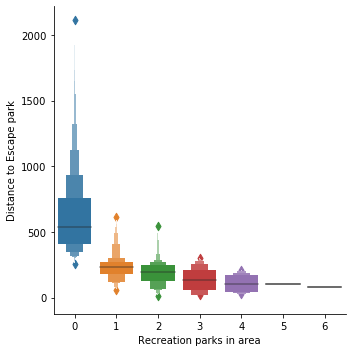

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
diamonds = sns.load_dataset("diamonds")
sns.catplot(x="Recreation parks in area", y="Distance to Escape park",kind="boxen", data=df_locations.sort_values("Recreation parks in area"))

In [22]:
parks_latlons = [[prk
[2], prk
[3]] for prk
 in parks.values()]

escape_latlons = [[prk
[2], prk
[3]] for prk
 in escape_parks.values()]

In [23]:
from folium import plugins
from folium.plugins import HeatMap

map_london = folium.Map(location=london_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_london) #cartodbpositron cartodbdark_matter
HeatMap(parks_latlons).add_to(map_london)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='red', icon='home')).add_to(map_london)
folium.Circle(london_center, radius=1000, fill=False, color='white').add_to(map_london)
folium.Circle(london_center, radius=2000, fill=False, color='white').add_to(map_london)
folium.Circle(london_center, radius=3000, fill=False, color='white').add_to(map_london)
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [24]:
from folium import plugins
from folium.plugins import HeatMap

map_london = folium.Map(location=london_center, zoom_start=13)
folium.TileLayer('cartodbpositron').add_to(map_london) #cartodbpositron cartodbdark_matter
HeatMap(escape_latlons).add_to(map_london)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='red', icon='home')).add_to(map_london)
folium.Circle(london_center, radius=1000, fill=False, color='white').add_to(map_london)
folium.Circle(london_center, radius=2000, fill=False, color='white').add_to(map_london)
folium.Circle(london_center, radius=3000, fill=False, color='white').add_to(map_london)
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [25]:
roi_x_min = london_center_x - 2000
roi_y_max = london_center_y + 1000
roi_width = 5000
roi_height = 5000
roi_center_x = roi_x_min + 2500
roi_center_y = roi_y_max - 2500
roi_center_lon, roi_center_lat = xy_to_lonlat(roi_center_x, roi_center_y)
roi_center = [roi_center_lat, roi_center_lon]

map_london = folium.Map(location=roi_center, zoom_start=14)
HeatMap(parks_latlons).add_to(map_london)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='red', icon='home')).add_to(map_london)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_london)
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [26]:
k = math.sqrt(3) / 2 # Vertical offset for hexagonal grid cells
x_step = 100
y_step = 100 * k 
roi_y_min = roi_center_y - 2500

roi_latitudes = []
roi_longitudes = []
roi_xs = []
roi_ys = []
for i in range(0, int(51/k)):
    y = roi_y_min + i * y_step
    x_offset = 50 if i%2==0 else 0
    for j in range(0, 51):
        x = roi_x_min + j * x_step + x_offset
        d = calc_xy_distance(roi_center_x, roi_center_y, x, y)
        if (d <= 2501):
            lon, lat = xy_to_lonlat(x, y)
            roi_latitudes.append(lat)
            roi_longitudes.append(lon)
            roi_xs.append(x)
            roi_ys.append(y)

print(len(roi_latitudes), 'candidate neighborhood centers generated.')

2261 candidate neighborhood centers generated.


In [27]:
def count_parks_nearby(x, y, parks, radius=250):    
    count = 0
    for res in parks.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=radius:
            count += 1
    return count

def find_nearest_park(x, y, parks):
    d_min = 100000
    for res in parks.values():
        res_x = res[7]; res_y = res[8]
        d = calc_xy_distance(x, y, res_x, res_y)
        if d<=d_min:
            d_min = d
    return d_min

roi_park_counts = []
roi_escape_distances = []

print('Generating data on location candidates... ', end='')
for x, y in zip(roi_xs, roi_ys):
    count = count_parks_nearby(x, y, parks, radius=250)
    roi_park_counts.append(count)
    distance = find_nearest_park(x, y, escape_parks)
    roi_escape_distances.append(distance)
print('done.')


Generating data on location candidates...done.


In [28]:
# Let's put this into dataframe
df_roi_locations = pd.DataFrame({'Latitude':roi_latitudes,
                                 'Longitude':roi_longitudes,
                                 'X':roi_xs,
                                 'Y':roi_ys,
                                 'Parks nearby':roi_park_counts,
                                 'Distance to Escape park':roi_escape_distances
                                 })

df_roi_locations.head(10)

Latitude  Longitude              X             Y  Parks nearby  \
0  59.298579  18.065191  674535.449946  6.577315e+06             0   
1  59.298538  18.066944  674635.449946  6.577315e+06             0   
2  59.299582  18.055618  673985.449946  6.577402e+06             0   
3  59.299541  18.057371  674085.449946  6.577402e+06             0   
4  59.299500  18.059124  674185.449946  6.577402e+06             0   
5  59.299459  18.060878  674285.449946  6.577402e+06             0   
6  59.299418  18.062631  674385.449946  6.577402e+06             0   
7  59.299376  18.064384  674485.449946  6.577402e+06             0   
8  59.299335  18.066138  674585.449946  6.577402e+06             0   
9  59.299294  18.067891  674685.449946  6.577402e+06             0   

   Distance to Escape park  
0               512.493985  
1               415.263836  
2               765.641760  
3               865.311506  
4               872.949664  
5               775.780307  
6               679.432891  
7               584.314147  
8               491.138465  
9               401.261711

Lets visualize our Data with a boxen plot

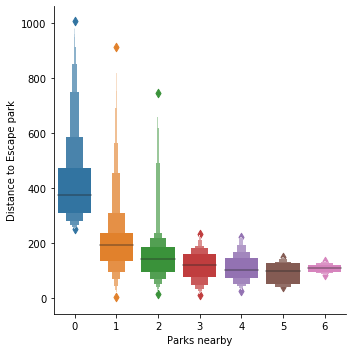

In [29]:
diamonds = sns.load_dataset("diamonds")
sns.catplot(x="Parks nearby", y="Distance to Escape park",kind="boxen", data=df_roi_locations.sort_values("Parks nearby"))

In [30]:
good_park_count = np.array((df_roi_locations['Parks nearby']<=1))
print('Locations with no more than one park nearby:', good_park_count.sum())

good_esc_distance = np.array(df_roi_locations['Distance to Escape park']>=300)
print('Locations with no Escape parks within 250m:', good_esc_distance.sum())

good_locations = np.logical_and(good_park_count, good_esc_distance) 
print('Locations with both conditions met:', good_locations.sum())

df_good_locations = df_roi_locations[good_locations]

Locations with no more than one park nearby: 1805
Locations with no Escape parks within 250m: 929
Locations with both conditions met: 917


In [31]:
good_latitudes = df_good_locations['Latitude'].values
good_longitudes = df_good_locations['Longitude'].values

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]

map_london = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_london)
HeatMap(parks_latlons).add_to(map_london)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.6).add_to(map_london)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='red', icon='home')).add_to(map_london)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_london) 
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [32]:
map_london = folium.Map(location=roi_center, zoom_start=14)
HeatMap(good_locations, radius=25).add_to(map_london)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='red', icon='home')).add_to(map_london)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_london)
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [33]:
from sklearn.cluster import KMeans

number_of_clusters = 15

good_xys = df_good_locations[['X', 'Y']].values
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(good_xys)

cluster_centers = [xy_to_lonlat(cc[0], cc[1]) for cc in kmeans.cluster_centers_]

map_london = folium.Map(location=roi_center, zoom_start=14)
folium.TileLayer('cartodbpositron').add_to(map_london)
HeatMap(parks_latlons).add_to(map_london)
folium.Circle(roi_center, radius=2500, color='white', fill=True, fill_opacity=0.4).add_to(map_london)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='red', icon='home')).add_to(map_london)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='green', fill=True, fill_opacity=0.25).add_to(map_london) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_london)
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [34]:
map_london = folium.Map(location=roi_center, zoom_start=14)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='red', icon='home')).add_to(map_london)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#00000000', fill=True, fill_color='#0066ff', fill_opacity=0.07).add_to(map_london)
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.CircleMarker([lat, lon], radius=2, color='blue', fill=True, fill_color='blue', fill_opacity=1).add_to(map_london)
for lon, lat in cluster_centers:
    folium.Circle([lat, lon], radius=500, color='red', fill=False).add_to(map_london) 
# folium.GeoJson(london_boroughs, style_function=boroughs_style, name='geojson').add_to(map_london)
map_london

In [35]:
candidate_area_addresses = []
print('\n\t==============================================================')
print('\tAddresses of centers of areas recommended for further analysis')
print('\t==============================================================\n')
for lon, lat in cluster_centers:
    addr = get_address(google_api_key, lat, lon).replace(', Germany', '')
    candidate_area_addresses.append(addr)    
    x, y = lonlat_to_xy(lon, lat)
    d = calc_xy_distance(x, y, london_center_x, london_center_y)
    print('{}{} => {:.1f}km from Charing Cross'.format(addr, ' '*(50-len(addr)), d/1000))
    


	Addresses of centers of areas recommended for further analysis

Svärdlångsvägen 2X, 120 60 Årsta, Sweden           => 3.3km from Charing Cross
Saltsjön, 116 45 Stockholm, Sweden                 => 3.1km from Charing Cross
Kungsgatan 50, 111 35 Stockholm, Sweden            => 0.1km from Charing Cross
Mälarvarvsbacken 5, 117 33 Stockholm, Sweden       => 2.1km from Charing Cross
Hammarby Slussväg 11, 118 60 Stockholm, Sweden     => 3.6km from Charing Cross
Skeppsbron 46, 111 30 Stockholm, Sweden            => 1.6km from Charing Cross
Tantolunden, gftg, Zinkens Väg, 118 42 Stockholm, Sweden => 2.5km from Charing Cross
Kungsholmstorg brygga, 112 20 Stockholm, Sweden    => 1.4km from Charing Cross
Söder Mälarstrand, Kajplats 13, 118 25 Stockholm, Sweden => 1.4km from Charing Cross
Strandvägen 7B U3, 114 56 Stockholm, Sweden        => 1.2km from Charing Cross
Tegelviksgatan 77, 116 47 Stockholm, Sweden        => 3.6km from Charing Cross
Örlogsvägen 11, 111 49 Stockholm, Sweden           =>

In [36]:
map_london = folium.Map(location=roi_center, zoom_start=14)
folium.Marker([latitude,longitude], popup='Charing Cross', icon=folium.Icon(color='red', icon='home')).add_to(map_london)
for lonlat, addr in zip(cluster_centers, candidate_area_addresses):
    folium.Marker([lonlat[1], lonlat[0]], popup=addr).add_to(map_london) 
for lat, lon in zip(good_latitudes, good_longitudes):
    folium.Circle([lat, lon], radius=250, color='#0000ff00', fill=True, fill_color='#0066ff', fill_opacity=0.05).add_to(map_london)
map_london